# Running a SepTop RBFE calculation

This tutorial gives a step-by-step process to set up a relative binding free energy (RBFE) simulation campaign using the [Separated Topologies Protocol](https://pubs.acs.org/doi/10.1021/acs.jctc.3c00282) in OpenFE.
In this tutorial we are performing a relative binding free energy calculation of two ligands binding to TYK2.

The relative binding free energy is obtained through a thermodynamic cycle. The ligands are transformed into each other both in solvent, giving 
$\Delta\Delta G$ (solvent) and in the complex, giving $\Delta\Delta G$ (complex), which allows calculation of the relative binding free energy, $\Delta\Delta G$. 
Each ligand is represented with its own set of coordinates, meaning that the interactions of all atoms of one ligand are turned off while simultaneously turning on the interactions of all atoms of the other ligand. Therefore, restraints are required: 
Ligands are restrained to the protein in the complex states using orientational (Boresch-style) restraints; in the solvent states ligands are restrained to remain apart from each other using a single harmonic distance restraint between the ligands. Restraints are not depicted in the thermodynamic cycle below for simplicity.

**Note:** In this `Protocol`, the coulombic interactions of the molecule are fully turned off (annihilated), while the Lennard-Jones interactions are decoupled, meaning the intermolecular interactions are turned off, while keeping the intramolecular Lennard-Jones interactions.

<img src="septop_cycle.png" width="600">

## 0. Setup for Google Colab

If you are running this example in Google Colab, run the following cells to setup the environment. If you are running this notebook locally, skip down to `1. Loading the ligands`

In [ ]:
# NBVAL_SKIP
# Only run this cell if on google colab
import os
if "COLAB_RELEASE_TAG" in os.environ:
    !pip install -q condacolab
    import condacolab
    condacolab.install_from_url("https://github.com/OpenFreeEnergy/ExampleNotebooks/releases/download/april-2025/OpenFEforge-1.5.0a0-Linux-x86_64.sh")

In [ ]:
# NBVAL_SKIP
# Only run this cell if on google colab
import os
if "COLAB_RELEASE_TAG" in os.environ:
    import condacolab
    import locale
    locale.getpreferredencoding = lambda: "UTF-8"
    !mkdir inputs && cd inputs && openfe fetch rbfe-tutorial
    for _ in range(3):
      # Sometimes we have to re-run the check
      try:
        condacolab.check()
      except:
        pass
      else:
        break

## 1. Loading the ligands

First we must load the chemical models between which we wish to calculate free energies.
In this example these are initially stored in a molfile (`.sdf`) containing multiple molecules.
This can be loaded using the `SDMolSupplier` class from rdkit and passed to openfe.

In [1]:
%matplotlib inline
import openfe

In [2]:
from rdkit import Chem
supp = Chem.SDMolSupplier("tyk2_ligands.sdf", removeHs=False)
ligands = [openfe.SmallMoleculeComponent.from_rdkit(mol) for mol in supp]

## 2. Charging the ligands

It is recommended to use a single set of charges for each ligand to ensure reproducibility between repeats or consistent charges between different legs of a calculation involving the same ligand, like a relative binding affinity calculation for example. 

Here we will use some utility functions from OpenFE which can assign partial charges to a series of molecules with a variety of methods which can be configured via the `OpenFFPartialChargeSettings` class. In this example 
we will charge the ligands using the `am1bcc` method from `ambertools` which is the default charge scheme used by OpenFE.

In [3]:
from openfe.protocols.openmm_utils.omm_settings import OpenFFPartialChargeSettings
from openfe.protocols.openmm_utils.charge_generation import bulk_assign_partial_charges

charge_settings = OpenFFPartialChargeSettings(partial_charge_method="am1bcc", off_toolkit_backend="ambertools")

charged_ligands = bulk_assign_partial_charges(
    molecules=ligands,
    overwrite=False,  
    method=charge_settings.partial_charge_method,
    toolkit_backend=charge_settings.off_toolkit_backend,
    generate_n_conformers=charge_settings.number_of_conformers,
    nagl_model=charge_settings.nagl_model,
    processors=1
)

Generating charges: 100%|███████████████████████| 10/10 [02:54<00:00, 17.43s/it]


## 3. Creating the `LigandNetwork`

The first step is to create a `LigandNetwork`. Here, we will be using the same process as in the relative hybrid topology `Protocol`, including the use of a mapper which is required by the scorer. **The mappings will not be used in the `Protocol`.** This is a temporary solution until we have developed a scorer specifically for the `SepTopProtocol`. Alternatively, the user can also manually define the edges they want to run when creating the transformations below, without creating a `LigandNetwork` first.

The pipeline for creating a `LigandNetwork` can involve three components:

1. **Atom Mapper**: Proposes potential atom mappings (descriptions of the alchemical change) for pairs of ligands. We will use the `LomapAtomMapper`. *The atom mapping will only be used to score the potential edges, the atom mapping is not used outside of the scorer*.
2. **Scorer**: Given an atom mapping, provides an estimate of the quality of that mapping (higher scores are better). We will use `default_lomap_scorer`.
3. **Network Planner**: Creates the actual `LigandNetwork`; different network planners provide different strategies. We will create a minimal spanning network with the `generate_minimal_spanning_network` method.

Each of these components could be replaced by other options.

In [4]:
mapper = openfe.LomapAtomMapper(max3d=1.0, element_change=False)
scorer = openfe.lomap_scorers.default_lomap_score
network_planner = openfe.ligand_network_planning.generate_minimal_spanning_network

The exact call signature depends on the network planner: a minimal spanning network requires a score, whereas that is optional for a radial network (but a radial network needs the central ligand to be provided).

In [5]:
ligand_network = network_planner(
    ligands=charged_ligands,
    mappers=[mapper],
    scorer=scorer
)

Now we can look at the overall structure of the `LigandNetwork`:

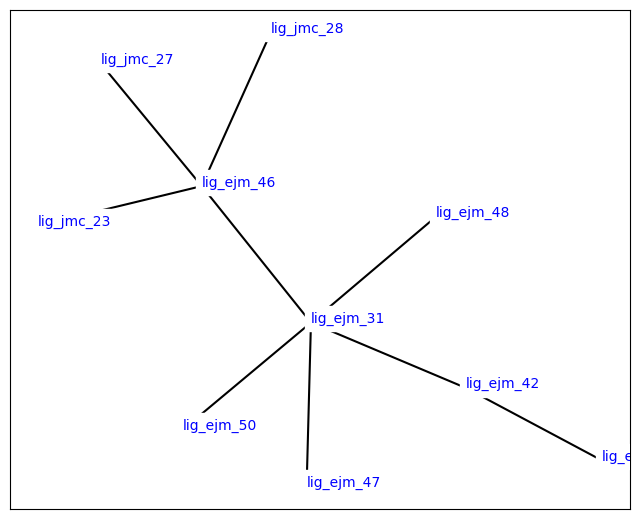

In [6]:
from openfe.utils.atommapping_network_plotting import plot_atommapping_network
plot_atommapping_network(ligand_network)

You can output the ligand network to the same `graphml` format as we saw in the CLI tutorial with the following:

In [7]:
with open("ligand_network.graphml", mode='w') as f:
    f.write(ligand_network.to_graphml())

## 4. Creating a single `Transformation`

The `LigandNetwork` only knows about the small molecules and the alchemical connections between them. It doesn't know anything about environment (e.g., solvent) or about the `Protocol` that will be used during the simulation.

That information in included in a `Transformation`. Each of these transformations corresponds to a thermodynamic cycle of one ligand transformation, including the complex and the solvent leg.

In practice, this will be done for each edge of the `LigandNetwork` in a loop, but for illustrative purposes we'll dive into the details of creating a single transformation.

### Creating `ChemicalSystem`s

OpenFE describes complex molecular systems as being composed of `Component`s. For example, we have `SmallMoleculeComponent` for each small molecule in the `LigandNetwork`. We'll create a `SolventComponent` to describe the solvent, and a `ProteinComponent` for the protein.

The `Component`s are joined in a `ChemicalSystem` to define the entire system.

In state A of the `SepTopProtocol`, the ligand A is fully interacting in the complex and the ChemicalSystem contains the ligand A, the protein, and the solvent. Ligand B is fully decoupled in this state. In the other endstate, state B, ligand B is fully interacting in the complex while ligand A is decoupled. Therefore, the ChemicalSystem in state B only contains the ligand B, protein and the solvent.

Note that for SepTop simulations, we are not separately defining the end states of the solvent leg, but the `Protocol` creates that based on the complex states.

In [8]:
# defaults are water with NaCl at 0.15 M
solvent = openfe.SolventComponent()

In [9]:
protein = openfe.ProteinComponent.from_pdb_file("./tyk2_protein.pdb")

In [10]:
systemA = openfe.ChemicalSystem({
    'ligand': charged_ligands[0],
    'solvent': solvent,
    'protein': protein
})
systemB = openfe.ChemicalSystem({
    'ligand': charged_ligands[1],
    'solvent': solvent,
    'protein': protein    
})

### Creating a `Protocol`

The actual simulation is performed by a `Protocol`. We'll use an OpenMM-based separated topologies relative free energy `Protocol`.

In [11]:
from openfe.protocols.openmm_septop import SepTopProtocol

/Users/hannahbaumann/miniforge3/envs/septop/lib/python3.12/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


There are various different parameters which can be set to determine how the SepTop simulation will take place.

The easiest way to customize protocol settings is to start with the default settings, and modify them. Many settings carry units with them.

In [12]:
from openff.units import unit
settings = SepTopProtocol.default_settings()

# Run only a single repeat
settings.protocol_repeats = 1
# Change the min and max distance between protein and ligand atoms for Boresch restraints to avoid periodicity issues
settings.complex_restraint_settings.host_min_distance = 0.5 * unit.nanometer
settings.complex_restraint_settings.host_max_distance = 1.5 * unit.nanometer
# Set the equilibration time to 2 ns (which is also the default)
settings.solvent_simulation_settings.equilibration_length = 2000 * unit.picosecond
settings.complex_simulation_settings.equilibration_length = 2000 * unit.picosecond

In [13]:
protocol = SepTopProtocol(settings)

### Creating the `Transformation`

Once we have the mapping, the two `ChemicalSystem`s, and the `Protocol`, creating the `Transformation` is easy:

In [14]:
transformation = openfe.Transformation(
    systemA,
    systemB,
    protocol,
    mapping=None,
)

To summarize, this `Transformation` contains:
- chemical models of both sides of the alchemical transformation in `systemA` and `systemB`
- a description of the exact computational algorithm to use to perform the estimate in `Protocol`

**The `mapping` is set to `None` since no atoms are mapped in the SepTop protocol.**

## 5. Creating the `AlchemicalNetwork`

The `AlchemicalNetwork` contains all the information needed to run the entire campaign. It consists of a `Transformation` for each edge of the campaign. We'll loop over all the edges to make each transformation.

In [15]:
transformations = []
for edge in ligand_network.edges:
    # use the solvent and protein created above
    sysA_dict = {'ligand': edge.componentA,
                 'protein': protein,
                 'solvent': solvent}
    sysB_dict = {'ligand': edge.componentB,
                 'protein': protein,
                 'solvent': solvent}
    
    # we don't have to name objects, but it can make things (like filenames) more convenient
    sysA = openfe.ChemicalSystem(sysA_dict, name=f"{edge.componentA.name}")
    sysB = openfe.ChemicalSystem(sysB_dict, name=f"{edge.componentB.name}")
    
    prefix = "rbfe_"  # prefix is only to exactly reproduce CLI
    
    transformation = openfe.Transformation(
        stateA=sysA,
        stateB=sysB,
        mapping=None,
        protocol=protocol,  # use protocol created above
        name=f"{prefix}{sysA.name}_{sysB.name}"
    )
    transformations.append(transformation)

network = openfe.AlchemicalNetwork(transformations)

## 6. Running the SepTop simulations using the OpenFE CLI

We'll write out each transformation to disk, so that they can be run independently using the `openfe quickrun` command:

In [16]:
import pathlib
# first we create the directory
transformation_dir = pathlib.Path("transformations")
transformation_dir.mkdir(exist_ok=True)

# then we write out each transformation
for transformation in network.edges:
    transformation.dump(transformation_dir / f"{transformation.name}.json")

/Users/hannahbaumann/miniforge3/envs/septop/lib/python3.12/site-packages/gufe/transformations/transformation.py:124: DeprecationWarning: use of this method is deprecated; instead use `to_json`
  warnings.warn(
/Users/hannahbaumann/miniforge3/envs/septop/lib/python3.12/site-packages/gufe/transformations/transformation.py:124: DeprecationWarning: use of this method is deprecated; instead use `to_json`
  warnings.warn(
/Users/hannahbaumann/miniforge3/envs/septop/lib/python3.12/site-packages/gufe/transformations/transformation.py:124: DeprecationWarning: use of this method is deprecated; instead use `to_json`
  warnings.warn(
/Users/hannahbaumann/miniforge3/envs/septop/lib/python3.12/site-packages/gufe/transformations/transformation.py:124: DeprecationWarning: use of this method is deprecated; instead use `to_json`
  warnings.warn(
/Users/hannahbaumann/miniforge3/envs/septop/lib/python3.12/site-packages/gufe/transformations/transformation.py:124: DeprecationWarning: use of this method is d

In [17]:
!ls transformations/

rbfe_lig_ejm_31_lig_ejm_42.json rbfe_lig_ejm_42_lig_ejm_43.json
rbfe_lig_ejm_31_lig_ejm_46.json rbfe_lig_ejm_46_lig_jmc_23.json
rbfe_lig_ejm_31_lig_ejm_47.json rbfe_lig_ejm_46_lig_jmc_27.json
rbfe_lig_ejm_31_lig_ejm_48.json rbfe_lig_ejm_46_lig_jmc_28.json
rbfe_lig_ejm_31_lig_ejm_50.json


/Users/hannahbaumann/miniforge3/envs/septop/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=26930) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


Each of these individual `.json` files contains a `Transformation`, which contains all the information to run the calculation.  These could be farmed out as individual jobs on a HPC cluster.

You can run the SepTop simulation from the CLI by using the `openfe quickrun` command. It takes a transformation JSON as input, and the flags -o to give the final output JSON file and -d for the directory where simulation results should be stored. For example,

`openfe quickrun path/to/transformation.json -o results.json -d working-directory`

where path/to/transformation.json is the path to one of the files created above.

## 7. Analysis

Finally now that we've run our simulations, let's go ahead and gather the free energies for both phases.
If you ran the simulation using the CLI (i.e. by calling openfe quickrun ) you will end up with a JSON output file for each transformation. To get your simulation results you can load them back into Python in the following manner:

In [18]:
import gzip
import json
import gufe

outfile = "results/rbfe_lig_ejm_31_lig_ejm_42.json"
with open(outfile) as stream:
    results = json.load(stream)
    estimate = results['estimate']
    uncertainty = results['uncertainty']

In [19]:
estimate

{'magnitude': -1.0343272142162547,
 'unit': 'kilocalorie_per_mole',
 ':is_custom:': True,
 'pint_unit_registry': 'openff_units'}